In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



#Funciones de Python creadas por equipo Simulacion
from funcioneschicuadrado_continuas import*
from funciones_KS_test import*
from funciones_qq_pp_plot import*

In [31]:
datos_llegada_aviones=pd.read_excel('Datos-Caso-III.xlsx',sheet_name='DatosLlegadaAviones')
datos_llegada_aviones['Fecha de Llegada'] = pd.to_datetime(datos_llegada_aviones['Fecha de Llegada'])
datos_llegada_aviones.head()

,Fecha de Llegada,Tipo de Avión
0,2023-05-01 00:00:00.000,Mediano
1,2023-05-01 00:12:48.533,Grande
2,2023-05-01 00:20:31.919,Mediano
3,2023-05-01 00:31:48.641,Pequeño
4,2023-05-01 00:40:09.796,Pequeño


In [32]:
datos_pasajeros=pd.read_excel('Datos-Caso-III.xlsx',sheet_name='DatosPasajeros')
datos_pasajeros.head()

,Pasajero,Tipo de pasaporte,¿Lleva maleta?
0,1,Extranjero,Sí
1,2,Nacional no biométrico,No
2,3,Nacional no biométrico,Sí
3,4,Nacional no biométrico,Sí
4,5,Nacional no biométrico,Sí


In [33]:
datos_tiempo_servicio=pd.read_excel('Datos-Caso-III.xlsx',sheet_name='TiempoDeServicioBiométrico')
datos_tiempo_servicio.head()

,Persona atendida,Tipo de pasaporte,Tiempo de servicio (minutos)
0,1,Biométrico,0.349995
1,2,Biométrico,2.046627
2,3,Biométrico,0.232612
3,4,Biométrico,1.085411
4,5,Biométrico,2.585409


#### a.  Tiempo entre arribos de un avión desde un destino internacional para cada una de las siguientes franjas cuatro horarias: (6:00 am – 11:00 am; 11:00 am – 3:00 pm; 3:00 pm – 9:00 pm; 9:00 pm – 6:00 am) 

In [34]:
def asignar_franja(row):
    hora = row.hour
    if 6 <= hora < 11:
        return '6:00 am - 11:00 am'
    elif 11 <= hora < 15:
        return '11:00 am - 3:00 pm'
    elif 15 <= hora < 21:
        return '3:00 pm - 9:00 pm'
    else:
        return '9:00 pm - 6:00 am'

# Aplicar la función a la columna 'Fecha de Llegada'
datos_llegada_aviones['Franja Horaria'] = datos_llegada_aviones['Fecha de Llegada'].apply(asignar_franja)
datos_llegada_aviones.head()

,Fecha de Llegada,Tipo de Avión,Franja Horaria
0,2023-05-01 00:00:00.000,Mediano,9:00 pm - 6:00 am
1,2023-05-01 00:12:48.533,Grande,9:00 pm - 6:00 am
2,2023-05-01 00:20:31.919,Mediano,9:00 pm - 6:00 am
3,2023-05-01 00:31:48.641,Pequeño,9:00 pm - 6:00 am
4,2023-05-01 00:40:09.796,Pequeño,9:00 pm - 6:00 am


In [49]:
franjas = ['6:00 am - 11:00 am', '11:00 am - 3:00 pm', '3:00 pm - 9:00 pm', '9:00 pm - 6:00 am']


Inicialmente asignamos una franja horaria para para los datos de llegada, para despues proceder a hacer un analisis de tiempo entre llegadas para cada franja horaria

In [50]:
datos_llegada_aviones = datos_llegada_aviones.sort_values('Fecha de Llegada')

# Calcular el tiempo entre arribos
datos_llegada_aviones['Tiempo entre Arribos'] = datos_llegada_aviones['Fecha de Llegada']

# Filtrar datos para obtener tiempos entre arribos en cada franja horaria
datos_llegada_aviones['Tiempo entre Arribos (minutos)'] = datos_llegada_aviones['Fecha de Llegada'].diff().dt.total_seconds() / 60


datos_llegada_aviones.head()

,Fecha de Llegada,Tipo de Avión,Franja Horaria,Tiempo entre Arribos,Tiempo entre Arribos (minutos)
0,2023-05-01 00:00:00.000,Mediano,9:00 pm - 6:00 am,2023-05-01 00:00:00.000,NaN
1,2023-05-01 00:12:48.533,Grande,9:00 pm - 6:00 am,2023-05-01 00:12:48.533,12.808883
2,2023-05-01 00:20:31.919,Mediano,9:00 pm - 6:00 am,2023-05-01 00:20:31.919,7.723100
3,2023-05-01 00:31:48.641,Pequeño,9:00 pm - 6:00 am,2023-05-01 00:31:48.641,11.278700
4,2023-05-01 00:40:09.796,Pequeño,9:00 pm - 6:00 am,2023-05-01 00:40:09.796,8.352583


In [51]:
promedio_tiempo_entre_arribos = datos_llegada_aviones.groupby('Franja Horaria')['Tiempo entre Arribos (minutos)'].mean().reset_index()
print(promedio_tiempo_entre_arribos)

       Franja Horaria  Tiempo entre Arribos (minutos)
0  11:00 am - 3:00 pm                        3.788070
1   3:00 pm - 9:00 pm                        6.952127
2  6:00 am - 11:00 am                        6.054551
3   9:00 pm - 6:00 am                       10.997025


In [52]:
datos_llegada_aviones['Franja Horaria'].value_counts()

Franja Horaria
11:00 am - 3:00 pm    1289
6:00 am - 11:00 am    1046
3:00 pm - 9:00 pm     1021
9:00 pm - 6:00 am     1018
Name: count, dtype: int64

Primero se separan las franjas horarias usando pd.to_datetime para manejar fechas y horas, y se separan las 4 franjas mencionadas. Posterior a esto se calcula el tiempo entre arribos calculado en minutos (este puede ser convertido a cualquier tipo de unidad de tiempo mas adelante)

In [53]:
def aplicar_pruebas_bondad_ajuste(data):
    print("\nEvaluando bondad de ajuste para distribución Normal:")
    chi_square_normal_goodness_of_fit(data)

    print("\nEvaluando bondad de ajuste para distribución Exponencial:")
    chi_square_exponential_goodness_of_fit(data)

    print("\nEvaluando bondad de ajuste para distribución Lognormal:")
    chi_square_lognormal_goodness_of_fit(data)

    print("\nEvaluando bondad de ajuste para distribución Uniforme:")
    chi_square_uniform_goodness_of_fit(data)

    print("\nEvaluando bondad de ajuste para distribución Triangular:")
    chi_square_triangular_goodness_of_fit(data)

    print("\nEvaluando bondad de ajuste para distribución Gamma:")
    chi_square_gamma_goodness_of_fit(data)

    print("\nEvaluando bondad de ajuste para distribución Weibull:")
    chi_square_weibull_goodness_of_fit(data)


In [54]:
for franja in franjas:
    print(f"\n--- Análisis para la franja horaria: {franja} ---")
    datos_franja = datos_llegada_aviones[datos_llegada_aviones['Franja Horaria'] == franja]
    tiempos_entre_arribos = datos_franja['Tiempo entre Arribos (minutos)'].dropna()
    aplicar_pruebas_bondad_ajuste(tiempos_entre_arribos)



--- Análisis para la franja horaria: 6:00 am - 11:00 am ---

Evaluando bondad de ajuste para distribución Normal:
Parámetro estimado: Media = 6.054550987890376
Parámetro estimado: Desviación Estándar = 5.817594707503694
Chi-squared statistic: 824.2562095748668
p-value: 0.0

Evaluando bondad de ajuste para distribución Exponencial:
Parámetro estimado: Tasa = 0.16516501421824448
Chi-squared statistic: 198.0095556551723
p-value: 0.6611221871041646

Evaluando bondad de ajuste para distribución Lognormal:
Parámetro estimado (lognormal asociada): Media = 1.2517153587480148
Parámetro estimado (lognormal asociada): Desviación Estándar = 1.2484059611884557
Chi-squared statistic: 392.22370936902405
p-value: 9.914291609902648e-14

Evaluando bondad de ajuste para distribución Uniforme:
Parámetro estimado: a = 0.0035499999999999998
Parámetro estimado: b = 45.93255
Chi-squared statistic: 3020.101333857844
p-value: 0.0

Evaluando bondad de ajuste para distribución Triangular:
Parámetro estimado: a =

c:\Users\WD\.ipython\Workspace Visual Code\Maestria\Mastertrack 3\Simulacion-Python\Semana 3\Caso\funcioneschicuadrado_continuas.py:350: RuntimeWarning: invalid value encountered in scalar divide
  chi_squared = sum((observed_frequencies[i] - expected_frequencies[i])**2 / expected_frequencies[i] for i in range(k-1))


Chi-squared statistic: 8273.010037038941
p-value: 0.0

Evaluando bondad de ajuste para distribución Lognormal:
Parámetro estimado (lognormal asociada): Media = 1.3126884223768747
Parámetro estimado (lognormal asociada): Desviación Estándar = 0.1682738789373307
Chi-squared statistic: 656.3444530643914
p-value: 0.0

Evaluando bondad de ajuste para distribución Uniforme:
Parámetro estimado: a = 1.0352833333333333
Parámetro estimado: b = 22.948566666666668
Chi-squared statistic: 19465.76876473481
p-value: 0.0

Evaluando bondad de ajuste para distribución Triangular:
Parámetro estimado: a = 1.0352833333333333
Parámetro estimado: b = 22.948566666666668
Parámetro estimado: c = 3.5780499999999997
Chi-squared statistic: 9526.65913468099
p-value: 0.0

Evaluando bondad de ajuste para distribución Gamma:
Parámetro estimado: Media = 3.7880701060253426
Parámetro estimado: Varianza = 1.256882341432874
Chi-squared statistic: nan
p-value: nan

Evaluando bondad de ajuste para distribución Weibull:
Parám

c:\Users\WD\.ipython\Workspace Visual Code\Maestria\Mastertrack 3\Simulacion-Python\Semana 3\Caso\funcioneschicuadrado_continuas.py:400: RuntimeWarning: divide by zero encountered in divide
  chi_squared = np.sum((observed_frequencies - expected_frequencies)**2 / expected_frequencies)
c:\Users\WD\.ipython\Workspace Visual Code\Maestria\Mastertrack 3\Simulacion-Python\Semana 3\Caso\funcioneschicuadrado_continuas.py:400: RuntimeWarning: invalid value encountered in divide
  chi_squared = np.sum((observed_frequencies - expected_frequencies)**2 / expected_frequencies)


Chi-squared statistic: 939.3212488717348
p-value: 0.0

Evaluando bondad de ajuste para distribución Exponencial:
Parámetro estimado: Tasa = 0.14384086652480504
Chi-squared statistic: 216.98824201570827
p-value: 0.22333319081337166

Evaluando bondad de ajuste para distribución Lognormal:
Parámetro estimado (lognormal asociada): Media = 1.3670338414458096
Parámetro estimado (lognormal asociada): Desviación Estándar = 1.2357034173948651
Chi-squared statistic: 312.692458374143
p-value: 7.399495436377634e-07

Evaluando bondad de ajuste para distribución Uniforme:
Parámetro estimado: a = 0.017816666666666665
Parámetro estimado: b = 53.4105
Chi-squared statistic: 3158.6944124368597
p-value: 0.0

Evaluando bondad de ajuste para distribución Triangular:
Parámetro estimado: a = 0.017816666666666665
Parámetro estimado: b = 53.4105
Parámetro estimado: c = 3.1682833333333336
Chi-squared statistic: 5981.516641455645
p-value: 0.0

Evaluando bondad de ajuste para distribución Gamma:
Parámetro estimado

Despues de revisar las distribuciones, fue posible ver con una prueba chi cuadrado las distribuciones con un P-value mayor a una significancia del 5%:

6:00 am - 11:00 am (Tanto Exponencial como Weibull)

11:00 am - 3:00 pm (Ninguna)

3:00 pm - 9:00 pm (Exponencial)

9:00 pm - 6:00 am (Ninguna)

Se observa entonces las distribuciones a las que pertenecerian cada franja horaria por su distribucion de tiempo entre llegadas, gracias a pruebas de bondad de ajuste con chicuadrado. (En anexos se pueden ver los qq & pp plot donde parecia haber cercania con una distribucion lognormal, sin embargo no pudo ser comprobado con Chicuadrado)

In [55]:
estadisticas_franja = datos_llegada_aviones.groupby('Franja Horaria')['Tiempo entre Arribos (minutos)'].agg(['mean', 'std']).reset_index()

# Renombrar las columnas para mayor claridad
estadisticas_franja.columns = ['Franja Horaria', 'Media (minutos)', 'Desviación Estándar (minutos)']

# Mostrar los resultados
print(estadisticas_franja)


       Franja Horaria  Media (minutos)  Desviación Estándar (minutos)
0  11:00 am - 3:00 pm         3.788070                       1.121543
1   3:00 pm - 9:00 pm         6.952127                       7.078321
2  6:00 am - 11:00 am         6.054551                       5.820378
3   9:00 pm - 6:00 am        10.997025                       2.639982


In [59]:
tiempos_entre_arribos_11_3 = datos_llegada_aviones[datos_llegada_aviones['Franja Horaria'] == '11:00 am - 3:00 pm']['Tiempo entre Arribos (minutos)'].dropna()

KS_test_lognormal(tiempos_entre_arribos_11_3,media=3.788070 ,desvesta=1.121543)

Kolmogorov Smirnov statistic: 1.0
p-value: 0.0


#### b. Tiempo de atención del módulo biométrico inteligente. (30 puntos)

In [38]:
media_tiempo = datos_tiempo_servicio['Tiempo de servicio (minutos)'].mean()
mediana_tiempo = datos_tiempo_servicio['Tiempo de servicio (minutos)'].median()
desviacion_estandar = datos_tiempo_servicio['Tiempo de servicio (minutos)'].std()
rango_intercuartilico = datos_tiempo_servicio['Tiempo de servicio (minutos)'].quantile(0.75) - datos_tiempo_servicio['Tiempo de servicio (minutos)'].quantile(0.25)

print(f"Media: {media_tiempo:.2f} minutos")
print(f"Mediana: {mediana_tiempo:.2f} minutos")
print(f"Desviación Estándar: {desviacion_estandar:.2f} minutos")
print(f"Rango Intercuartílico: {rango_intercuartilico:.2f} minutos")

Media: 1.34 minutos
Mediana: 0.92 minutos
Desviación Estándar: 1.33 minutos
Rango Intercuartílico: 1.48 minutos


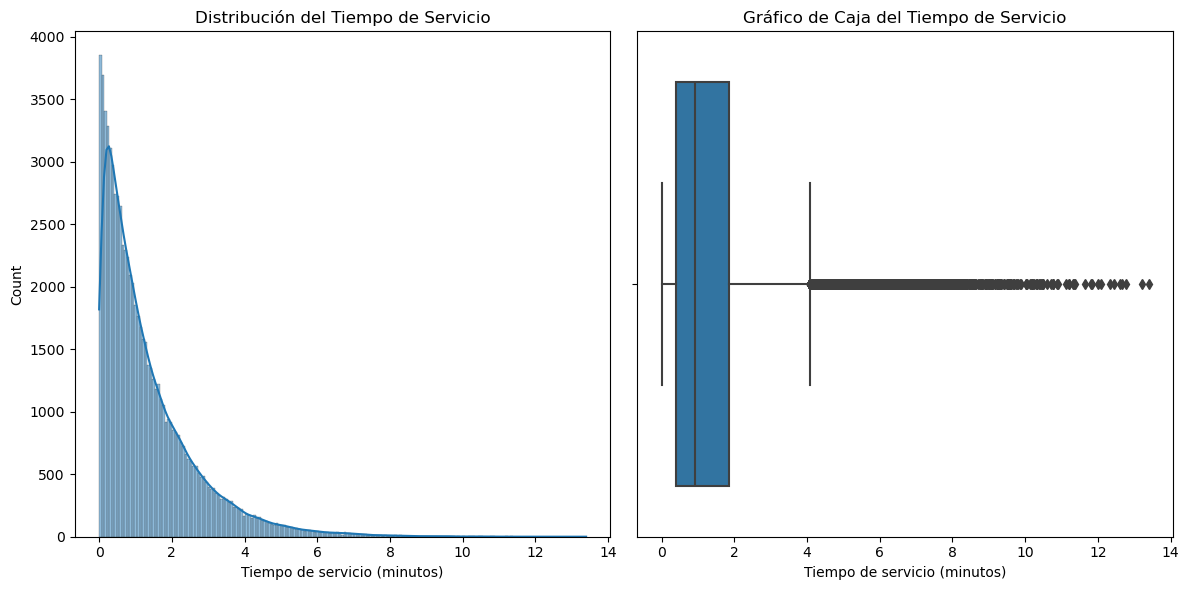

In [39]:
plt.figure(figsize=(12, 6))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(datos_tiempo_servicio['Tiempo de servicio (minutos)'], kde=True)
plt.title('Distribución del Tiempo de Servicio')

# Gráfico de Caja
plt.subplot(1, 2, 2)
sns.boxplot(x=datos_tiempo_servicio['Tiempo de servicio (minutos)'])
plt.title('Gráfico de Caja del Tiempo de Servicio')

plt.tight_layout()
plt.show()

#### c. Probabilidad de que el avión que acaba de aterrizar sea grande, mediano o pequeño. (10 puntos)

In [40]:
total_aviones = datos_llegada_aviones.shape[0]

conteo_por_tipo = datos_llegada_aviones['Tipo de Avión'].value_counts()

# Mostrar los conteos
print("Conteo por tipo de avión:")
print(conteo_por_tipo)

Conteo por tipo de avión:
Tipo de Avión
Mediano    2623
Grande     1314
Pequeño     437
Name: count, dtype: int64


In [41]:
probabilidades_tamano_avion = conteo_por_tipo / total_aviones

# Mostrar las probabilidades
print("\nProbabilidades de cada tipo de avión:")
print(probabilidades_tamano_avion)


Probabilidades de cada tipo de avión:
Tipo de Avión
Mediano    0.599680
Grande     0.300412
Pequeño    0.099909
Name: count, dtype: float64


#### d. Probabilidad asociada al tipo de pasajero/pasaporte. (10 puntos)

In [42]:
total_registros = datos_tiempo_servicio.shape[0]

# Contar la cantidad de cada tipo de pasaporte
conteo_por_tipo = datos_tiempo_servicio['Tipo de pasaporte'].value_counts()

print("Conteo por tipo de pasaporte:")
print(conteo_por_tipo)

Conteo por tipo de pasaporte:
Tipo de pasaporte
Biométrico    76203
Name: count, dtype: int64


In [29]:
probabilidades_tipo_pasajero = conteo_por_tipo / total_registros

# Mostrar las probabilidades
print("\nProbabilidades asociadas a cada tipo de pasaporte:")
print(probabilidades_tipo_pasajero)


Probabilidades asociadas a cada tipo de pasaporte:
Tipo de pasaporte
Biométrico    1.0
Name: count, dtype: float64


#### e. Probabilidad de que el pasajero haya viajado con maleta. (10 puntos)

In [44]:
total_pasajeros = datos_pasajeros.shape[0]
conteo_con_maleta = datos_pasajeros['¿Lleva maleta?'].value_counts().get('Sí', 0)

# Mostrar los conteos
print(f"Total de pasajeros: {total_pasajeros}")
print(f"Pasajeros con maleta: {conteo_con_maleta}")

probabilidad_con_maleta = conteo_con_maleta / total_pasajeros

# Mostrar la probabilidad
print(f"Probabilidad de que un pasajero haya viajado con maleta: {probabilidad_con_maleta:.2f}")


Total de pasajeros: 507530
Pasajeros con maleta: 372153
Probabilidad de que un pasajero haya viajado con maleta: 0.73


### Anexos

##### A continuacion se grafican PP y QQ plots para el tiempo entre arribos

Despues de revisar las distribuciones, fue posible ver que estos datos para las franjas horarias parecen tener ciertas distribuciones aunque no es facil de ver:

6:00 am - 11:00 am (Tanto Exponencial como Weibull)

11:00 am - 3:00 pm (la que mas se parece es Lognormal pero no es seguro)


3:00 pm - 9:00 pm (Exponencial y posiblemente Weibull)

9:00 pm - 6:00 am (Posiblemente Lognormal)

Esto no reemplaza unas pruebas de bondad de ajuste para comprobar todo de manera correcta


Análisis para la franja horaria: 6:00 am - 11:00 am
Parámetro estimado: Tasa = 0.16516501421824448


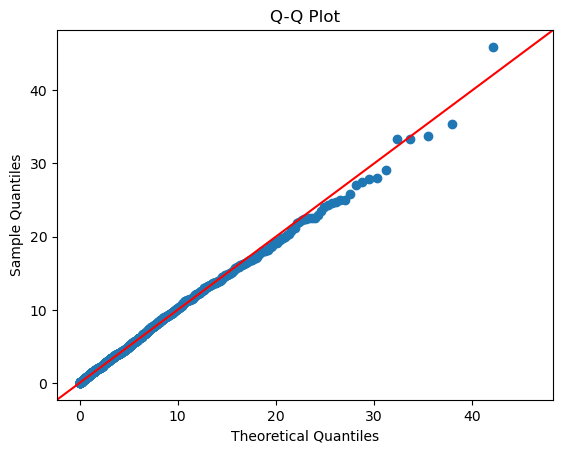

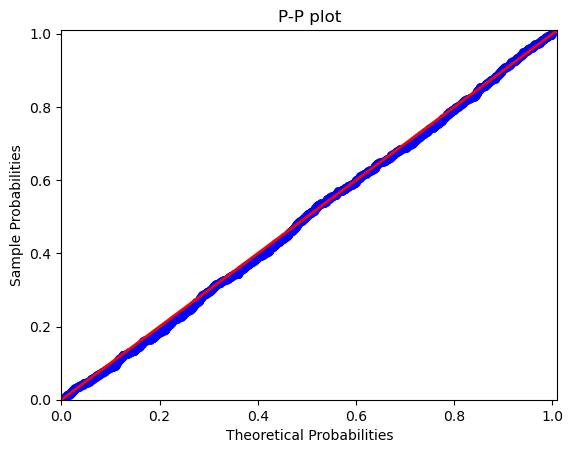

Análisis para la franja horaria: 11:00 am - 3:00 pm
Parámetro estimado: Tasa = 0.2639866665639028


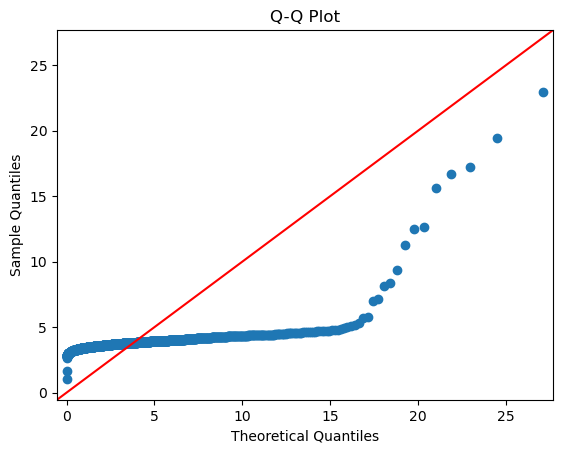

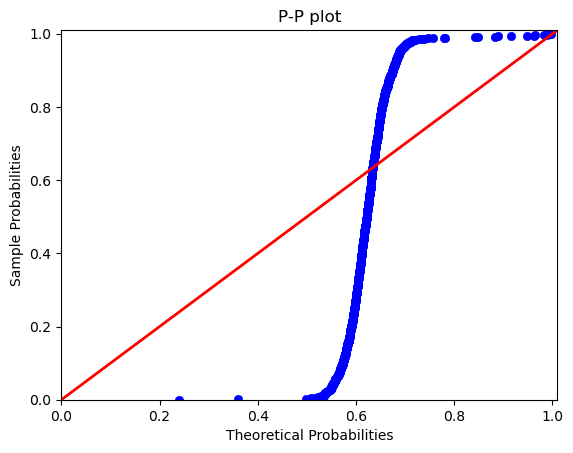

Análisis para la franja horaria: 3:00 pm - 9:00 pm
Parámetro estimado: Tasa = 0.14384086652480504


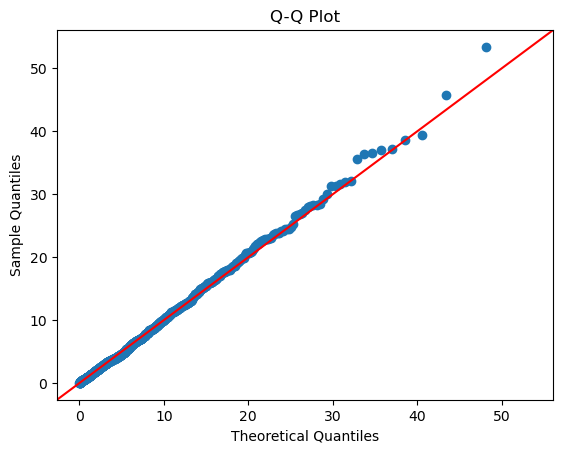

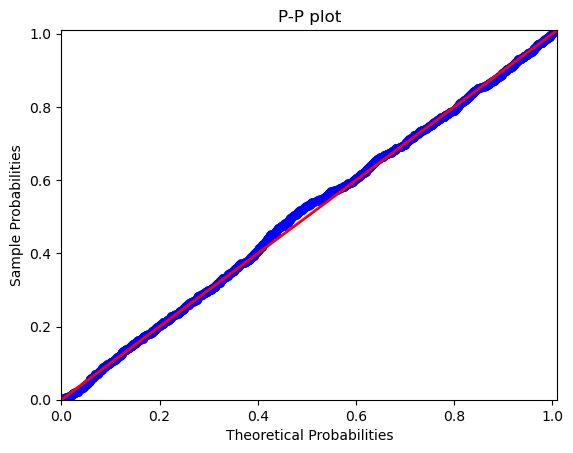

Análisis para la franja horaria: 9:00 pm - 6:00 am
Parámetro estimado: Tasa = 0.09093368359203953


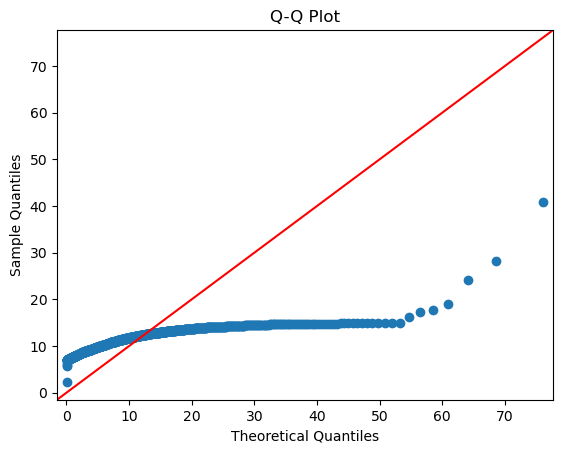

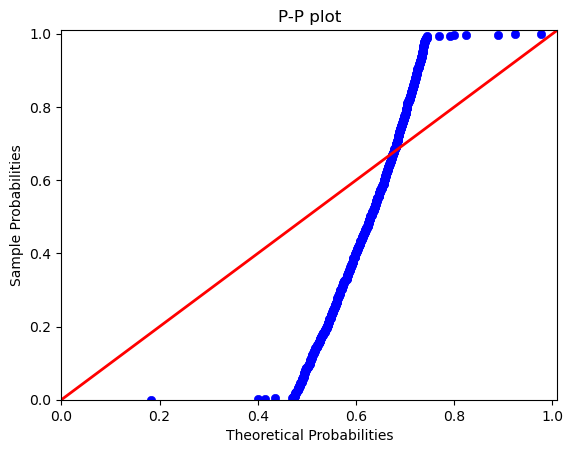

In [ ]:

for franja in franjas:
    print(f"Análisis para la franja horaria: {franja}")
    datos_franja = datos_llegada_aviones[datos_llegada_aviones['Franja Horaria'] == franja]
    tiempos_entre_arribos = datos_franja['Tiempo entre Arribos (minutos)'].dropna()
    PP_QQ_plot_exponential(tiempos_entre_arribos)

Análisis para la franja horaria: 6:00 am - 11:00 am
Parámetro estimado: Escala = 6.131169715335696
Parámetro estimado: Forma = 1.03155564197949


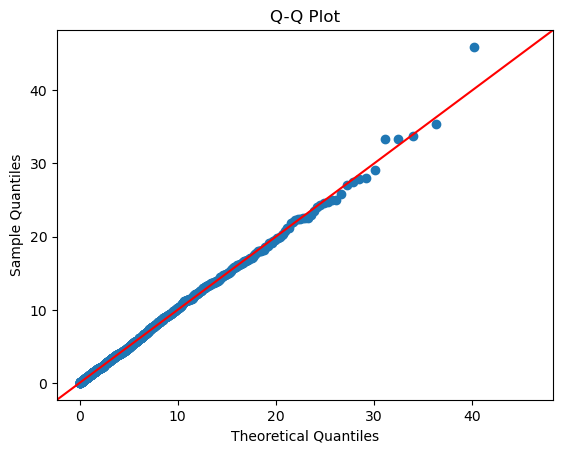

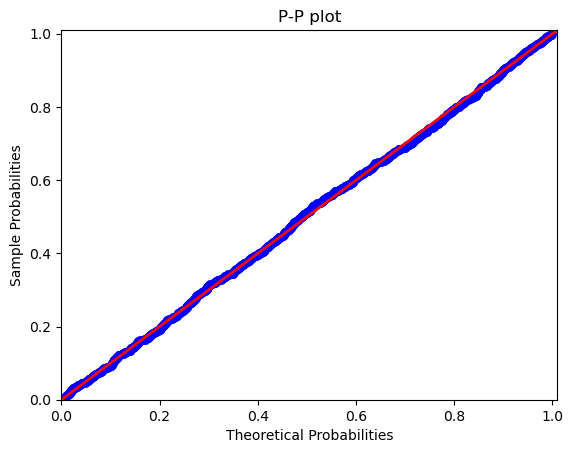

Análisis para la franja horaria: 11:00 am - 3:00 pm
Parámetro estimado: Escala = 4.149539229972704
Parámetro estimado: Forma = 2.586022917059287


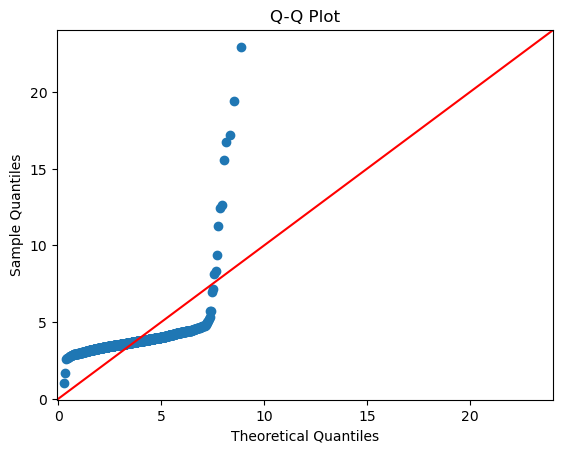

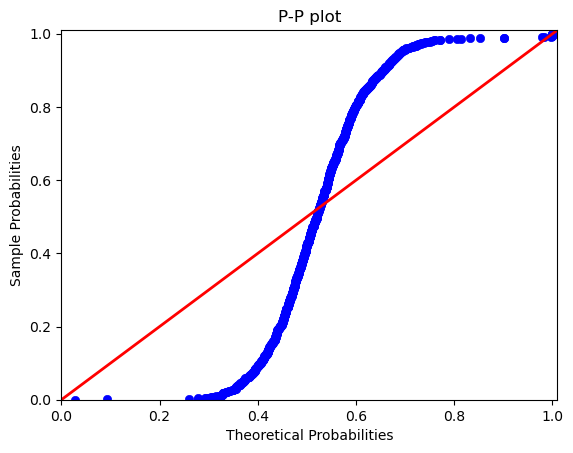

Análisis para la franja horaria: 3:00 pm - 9:00 pm
Parámetro estimado: Escala = 6.9403331859979165
Parámetro estimado: Forma = 0.9960848727898852


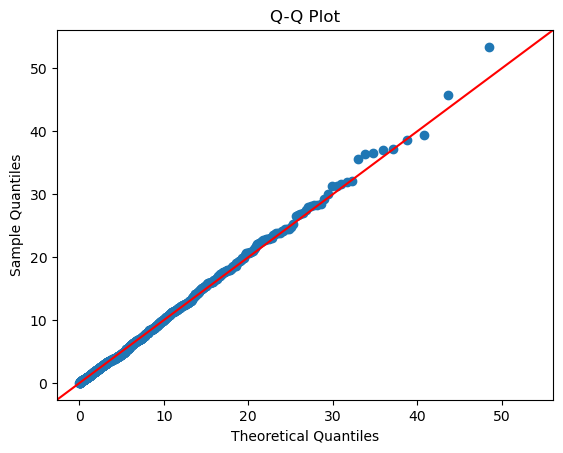

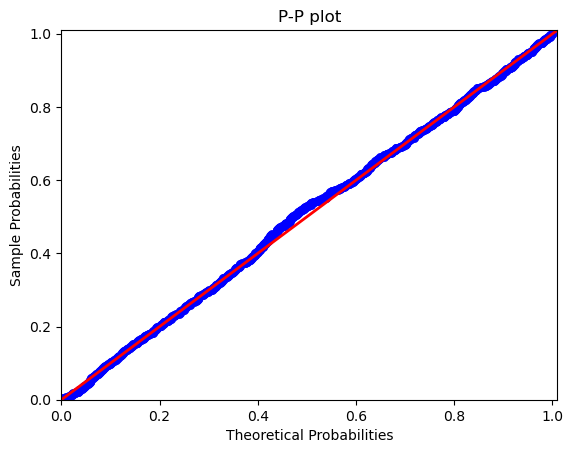

Análisis para la franja horaria: 9:00 pm - 6:00 am
Parámetro estimado: Escala = 11.977735085223983
Parámetro estimado: Forma = 3.6323313048883916


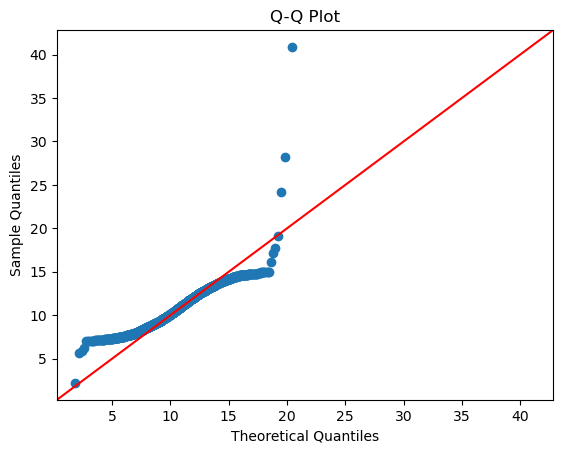

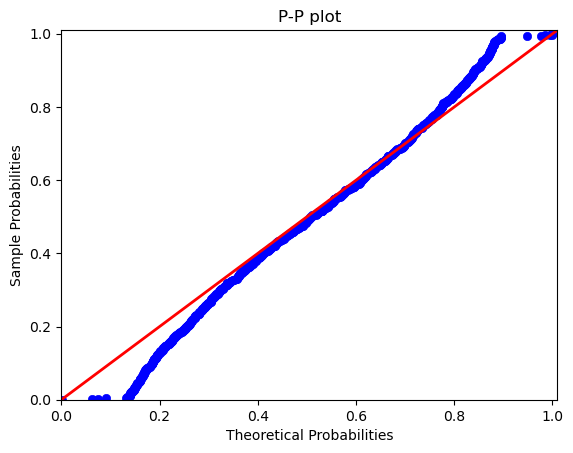

In [ ]:
for franja in franjas:
    print(f"Análisis para la franja horaria: {franja}")
    datos_franja = datos_llegada_aviones[datos_llegada_aviones['Franja Horaria'] == franja]
    tiempos_entre_arribos = datos_franja['Tiempo entre Arribos (minutos)'].dropna()
    PP_QQ_plot_weibull(tiempos_entre_arribos)

Análisis para la franja horaria: 6:00 am - 11:00 am
Parámetro estimado (normal asociada): Media = 1.2517153587480148
Parámetro estimado (normal asociada): Desviación Estándar = 1.2484059611884557


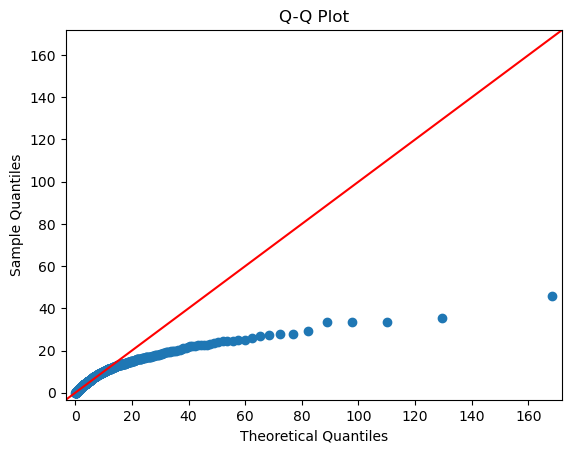

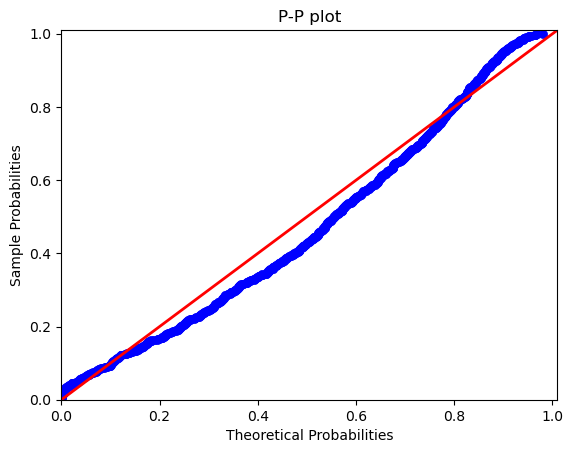

Análisis para la franja horaria: 11:00 am - 3:00 pm
Parámetro estimado (normal asociada): Media = 1.3126884223768747
Parámetro estimado (normal asociada): Desviación Estándar = 0.1682738789373307


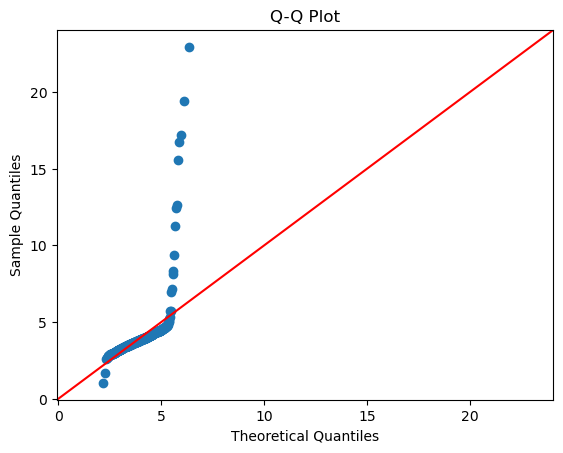

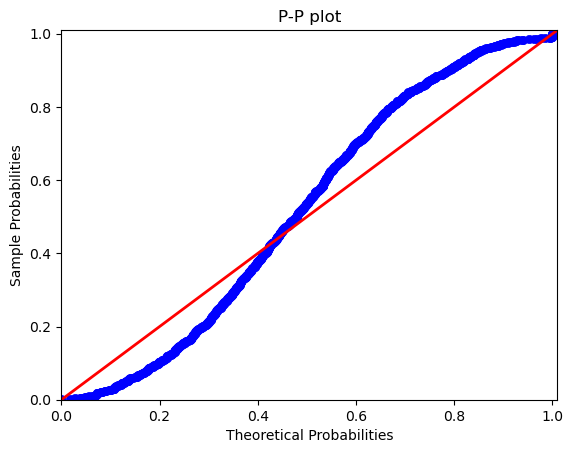

Análisis para la franja horaria: 3:00 pm - 9:00 pm
Parámetro estimado (normal asociada): Media = 1.3670338414458096
Parámetro estimado (normal asociada): Desviación Estándar = 1.2357034173948651


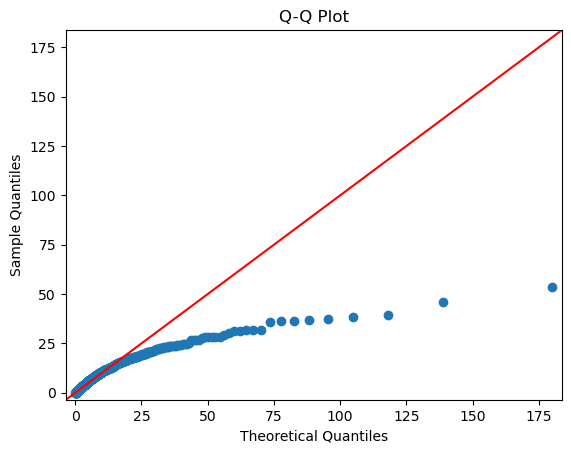

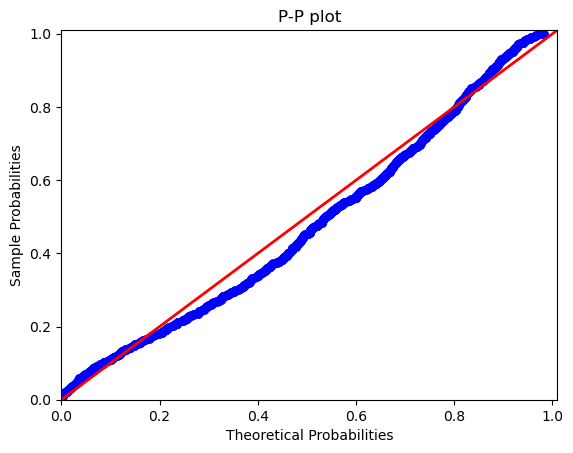

Análisis para la franja horaria: 9:00 pm - 6:00 am
Parámetro estimado (normal asociada): Media = 2.3704573876021735
Parámetro estimado (normal asociada): Desviación Estándar = 0.23399730381243314


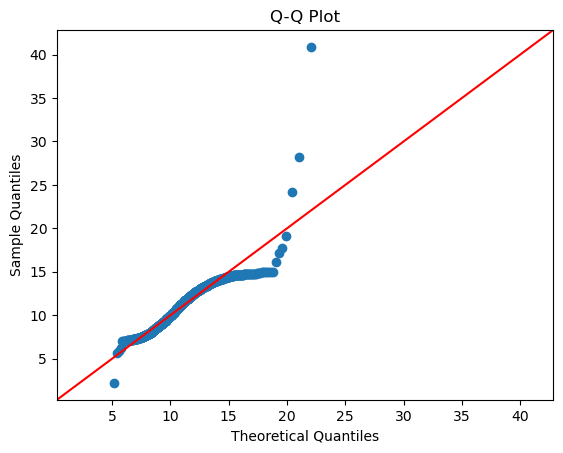

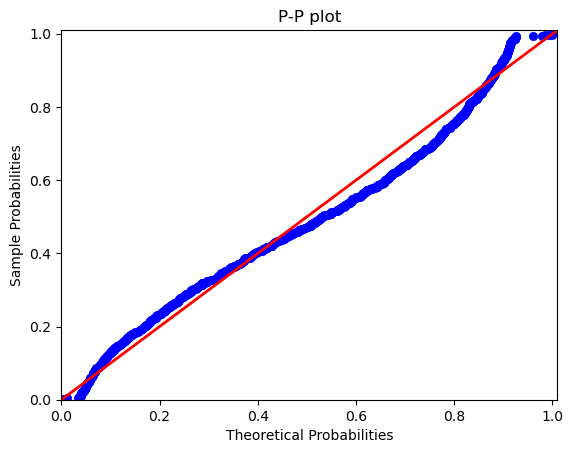

In [ ]:
for franja in franjas:
    print(f"Análisis para la franja horaria: {franja}")
    datos_franja = datos_llegada_aviones[datos_llegada_aviones['Franja Horaria'] == franja]
    tiempos_entre_arribos = datos_franja['Tiempo entre Arribos (minutos)'].dropna()
    PP_QQ_plot_lognormal(tiempos_entre_arribos)